In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import cv2
from torchvision import transforms
from PIL import Image
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
import timm
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

In [2]:
# ===================== SABİT DEĞERLER =====================
DATA_DIR = "C:/Users/zafer/OneDrive/Masaüstü/224NIH/dataset/images-224/images-224"
TRAIN_IMAGE_LIST = 'ChestX-ray14/labels/test_list.txt'
VAL_IMAGE_LIST = 'ChestX-ray14/labels/val_list.txt'
TEST_IMAGE_LIST = 'ChestX-ray14/labels/test_list.txt'
CKPT_PATH = ''  # Pretrained model path
SAVE_PATH = 'best_model/optimize_model.pth.tar'  # Path to save the trained model
N_CLASSES = 14
CLASS_NAMES = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass',
   'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
    'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'
]
BATCH_SIZE = 16
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
NUM_WORKERS = 0

In [3]:
# ===================== CLAHE TRANSFORM =====================
class CLAHETransform:
    """Görüntüye CLAHE (Kontrast Artırma) uygular ve Tensör formatına çevirir."""
    def __call__(self, img):
        if isinstance(img, torch.Tensor):
            img = transforms.ToPILImage()(img)
        
        img = np.array(img, dtype=np.uint8)
        
        if len(img.shape) == 3 and img.shape[2] == 3:
            lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            l = clahe.apply(l)
            lab = cv2.merge((l, a, b))
            img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
        elif len(img.shape) == 2:
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            img = clahe.apply(img)
        
        img = Image.fromarray(img)
        return img 

In [4]:

# ===================== GELİŞMİŞ AUGMENTASYON =====================
class CutMix:
    """CutMix Augmentasyonu uygular."""
    def __call__(self, img1, img2, alpha=1.0):
        lam = np.random.beta(alpha, alpha)
        h, w = img1.size  
        r_x = np.random.randint(w)
        r_y = np.random.randint(h)
        r_w = int(w * np.sqrt(1 - lam))
        r_h = int(h * np.sqrt(1 - lam))

        x1 = np.clip(r_x - r_w // 2, 0, w)
        x2 = np.clip(r_x + r_w // 2, 0, w)
        y1 = np.clip(r_y - r_h // 2, 0, h)
        y2 = np.clip(r_y + r_h // 2, 0, h)

        img1.paste(img2.crop((x1, y1, x2, y2)), (x1, y1, x2, y2))
        return img1

In [5]:
# ===================== MAX POOLING & TRANSFORMLAR =====================
def create_train_transforms():
    """Eğitim için max pooling ile veri dönüşümleri"""
    return transforms.Compose([
        CLAHETransform(),
        AutoAugment(AutoAugmentPolicy.IMAGENET),
        transforms.ToTensor(),
        nn.MaxPool2d(kernel_size=2, stride=2),  # Max Pooling ekleme
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [6]:

def create_val_transforms():
    """Doğrulama için max pooling ile veri dönüşümleri"""
    return transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        nn.MaxPool2d(kernel_size=2, stride=2),  
        CLAHETransform(),
        transforms.CenterCrop(224),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


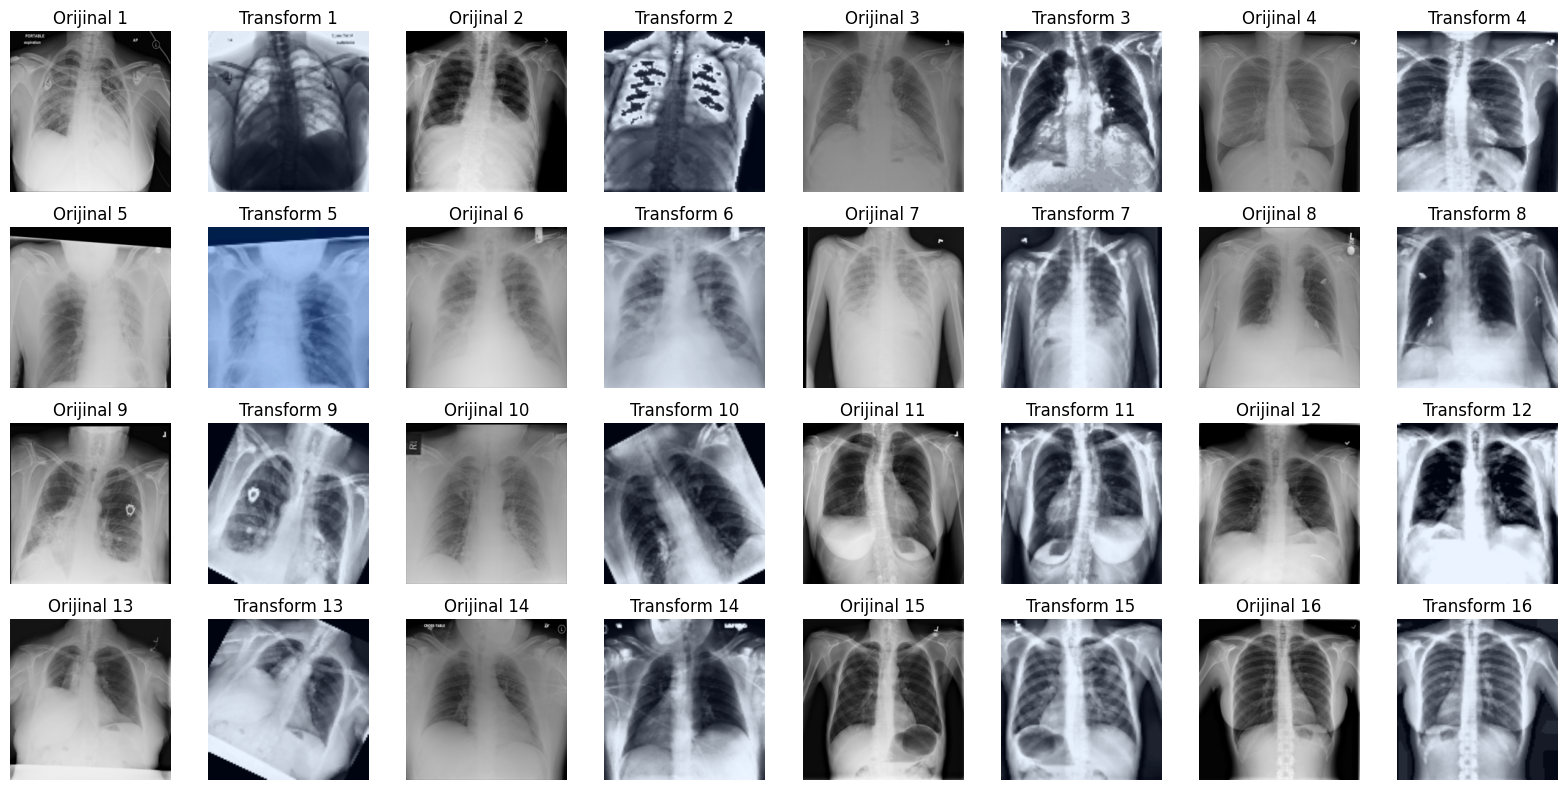

In [7]:
torch.manual_seed(42)  # Rastgeleliği kontrol etmek için
random.seed(42)

N_SAMPLES = 16
image_filenames = random.sample(os.listdir(DATA_DIR), N_SAMPLES)
original_images = []
transformed_images = []

# Görselleri yükle ve transform uygula
transform_pipeline = create_train_transforms()

for img_name in image_filenames:
    img_path = os.path.join(DATA_DIR, img_name)
    image = Image.open(img_path).convert("RGB")
    original_images.append(image)
    transformed_image = transform_pipeline(image)  # Transform uygula
    transformed_images.append(transformed_image)  # Dönüştürülmüş görüntüyü kaydet

# ===================== GÖRSELLERİ ÇİZ =====================
fig, axes = plt.subplots(4, 8, figsize=(16, 8))

for i in range(N_SAMPLES):
    # Orijinal Görüntü
    ax = axes[i // 4, (i % 4) * 2]
    ax.imshow(original_images[i])
    ax.set_title(f"Orijinal {i+1}")
    ax.axis("off")
    
    # Transform Sonrası Görüntü
    ax = axes[i // 4, (i % 4) * 2 + 1]
    transformed_image = transformed_images[i].permute(1, 2, 0).numpy()
    transformed_image = (transformed_image - transformed_image.min()) / (transformed_image.max() - transformed_image.min())  # Normalize et
    ax.imshow(transformed_image)
    ax.set_title(f"Transform {i+1}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [8]:

# ===================== EFFICIENTNET MODELİ =====================
class EfficientNetModel(nn.Module):
    """EfficientNet modeli çoklu sınıflandırma için düzenlendi."""
    def __init__(self, out_size):
        super(EfficientNetModel, self).__init__()
        self.model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=out_size)

    def forward(self, x):
        return self.model(x)


In [9]:
# ===================== FOCAL LOSS =====================
class FocalLoss(nn.Module):
    """Dengesiz veri setleri için Focal Loss uygular."""
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return loss.mean()


In [10]:
from torch.utils.data import Dataset

# ===================== CHEST X-RAY DATASET SINIFI =====================
class ChestXrayDataSet(Dataset):
    """Göğüs röntgeni görüntülerini ve multi-label etiketleri yükleyen sınıf."""
    def __init__(self, data_dir, image_list_file, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Etiketleri ve dosya isimlerini oku
        with open(image_list_file, "r") as f:
            for line in f.readlines():
                items = line.strip().split()
                image_name = items[0]  # İlk sütun dosya adı
                labels = np.array([int(x) for x in items[1:]], dtype=np.float32)  # Geri kalanlar etiketler
                self.image_paths.append(image_name)
                self.labels.append(labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.data_dir, self.image_paths[idx])
        image = Image.open(image_path).convert("RGB")  # Siyah beyaz olabilir, RGB'ye çeviriyoruz
        label = torch.tensor(self.labels[idx])  # Etiketleri tensöre çevir
        
        # Transform uygula (varsa)
        if self.transform:
            image = self.transform(image)
        
        return image, label  # Görsel + etiket döndür


In [11]:
from torch.utils.data import DataLoader

def get_dataloaders():
    """Eğitim, doğrulama ve test veri yükleyicilerini oluşturur."""
    
    # Eğitim veri kümesi
    train_dataset = ChestXrayDataSet(
        data_dir=DATA_DIR, 
        image_list_file=TRAIN_IMAGE_LIST, 
        transform=create_train_transforms()
    )

    # Doğrulama veri kümesi
    val_dataset = ChestXrayDataSet(
        data_dir=DATA_DIR, 
        image_list_file=VAL_IMAGE_LIST, 
        transform=create_train_transforms()
    )

    # Test veri kümesi
    test_dataset = ChestXrayDataSet(
        data_dir=DATA_DIR, 
        image_list_file=TEST_IMAGE_LIST, 
        transform=create_train_transforms()
    )

    # DataLoader tanımları
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

    return train_loader, val_loader, test_loader


In [12]:
def evaluate_model(model, val_loader):
    """Modeli doğrulama veri kümesi üzerinde değerlendirir ve AUROC skorunu hesaplar."""
    model.eval()  # Modeli evaluation moduna al
    gt, pred = [], []  # Gerçek ve tahmin değerlerini saklamak için

    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc="📊 AUROC Hesaplanıyor"):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)  # Sigmoid aktivasyonu uygula (Multi-label için)

            gt.append(targets.cpu().numpy())  # Gerçek etiketler
            pred.append(outputs.cpu().numpy())  # Tahmin edilen değerler

    # AUROC Hesapla
    gt = np.concatenate(gt, axis=0)
    pred = np.concatenate(pred, axis=0)
    aurocs = [roc_auc_score(gt[:, i], pred[:, i]) for i in range(gt.shape[1])]
    
    return np.mean(aurocs)  # Tüm sınıfların ortalama AUROC skoru


In [13]:
from sklearn.metrics import roc_auc_score

# ===================== MODEL EĞİTİMİ (AUROC EKLENDİ) =====================
def train_model(model, train_loader, val_loader, num_epochs, learning_rate):
    model = model.cuda()
    criterion = FocalLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scaler = GradScaler()
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, 
                                                    steps_per_epoch=len(train_loader), epochs=NUM_EPOCHS)

    best_auroc = 0.0  

    for epoch in range(num_epochs):
        print(f"📌 Epoch [{epoch + 1}/{num_epochs}] başlıyor...")
        
        model.train()
        train_loss = 0.0
        for inputs, targets in tqdm(train_loader, desc="🚀 Eğitim ilerliyor"):
            inputs, targets = inputs.cuda(), targets.cuda()
            optimizer.zero_grad()
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        print(f"🔹 Eğitim Kaybı: {train_loss:.4f}")

        # ===================== AUROC Skorunu Hesapla =====================
        val_auroc = evaluate_model(model, val_loader)
        print(f"✅ Validation AUROC: {val_auroc:.4f}")

        # AUROC Skoruna Göre Öğrenme Oranını Ayarla
        scheduler.step()

        # En iyi AUROC skoru takip et ve modeli kaydet
        if val_auroc > best_auroc:
            best_auroc = val_auroc
            torch.save(model.state_dict(), "best_model.pth")  # En iyi modeli kaydet
            print(f"🔥 Yeni en iyi model kaydedildi (AUROC: {best_auroc:.4f})")

    print("🎉 Eğitim tamamlandı!")
    print(f"⭐ En iyi AUROC skoru: {best_auroc:.4f}")


In [14]:
def main():
    train_loader, val_loader, test_loader = get_dataloaders()
    model = EfficientNetModel(N_CLASSES)
    train_model(model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE)


In [15]:
#run main
if __name__ == "__main__":
    main()

C:\Users\zafer\AppData\Local\Temp\ipykernel_22808\3822172866.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


📌 Epoch [1/10] başlıyor...


🚀 Eğitim ilerliyor:   0%|          | 0/1403 [00:00<?, ?it/s]C:\Users\zafer\AppData\Local\Temp\ipykernel_22808\3822172866.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
🚀 Eğitim ilerliyor: 100%|██████████| 1403/1403 [04:34<00:00,  5.11it/s]


🔹 Eğitim Kaybı: 0.0169


📊 AUROC Hesaplanıyor: 100%|██████████| 702/702 [01:35<00:00,  7.37it/s]


✅ Validation AUROC: 0.6260
🔥 Yeni en iyi model kaydedildi (AUROC: 0.6260)
📌 Epoch [2/10] başlıyor...


🚀 Eğitim ilerliyor:   0%|          | 0/1403 [00:00<?, ?it/s]C:\Users\zafer\AppData\Local\Temp\ipykernel_22808\3822172866.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
🚀 Eğitim ilerliyor: 100%|██████████| 1403/1403 [04:44<00:00,  4.92it/s]


🔹 Eğitim Kaybı: 0.0123


📊 AUROC Hesaplanıyor: 100%|██████████| 702/702 [01:27<00:00,  7.99it/s]


✅ Validation AUROC: 0.6881
🔥 Yeni en iyi model kaydedildi (AUROC: 0.6881)
📌 Epoch [3/10] başlıyor...


🚀 Eğitim ilerliyor:   0%|          | 0/1403 [00:00<?, ?it/s]C:\Users\zafer\AppData\Local\Temp\ipykernel_22808\3822172866.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
🚀 Eğitim ilerliyor: 100%|██████████| 1403/1403 [04:35<00:00,  5.09it/s]


🔹 Eğitim Kaybı: 0.0118


📊 AUROC Hesaplanıyor: 100%|██████████| 702/702 [01:58<00:00,  5.93it/s]


✅ Validation AUROC: 0.7273
🔥 Yeni en iyi model kaydedildi (AUROC: 0.7273)
📌 Epoch [4/10] başlıyor...


🚀 Eğitim ilerliyor:   0%|          | 0/1403 [00:00<?, ?it/s]C:\Users\zafer\AppData\Local\Temp\ipykernel_22808\3822172866.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
🚀 Eğitim ilerliyor: 100%|██████████| 1403/1403 [07:07<00:00,  3.28it/s]


🔹 Eğitim Kaybı: 0.0115


📊 AUROC Hesaplanıyor: 100%|██████████| 702/702 [01:56<00:00,  6.05it/s]


✅ Validation AUROC: 0.7530
🔥 Yeni en iyi model kaydedildi (AUROC: 0.7530)
📌 Epoch [5/10] başlıyor...


🚀 Eğitim ilerliyor:   0%|          | 0/1403 [00:00<?, ?it/s]C:\Users\zafer\AppData\Local\Temp\ipykernel_22808\3822172866.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
🚀 Eğitim ilerliyor: 100%|██████████| 1403/1403 [06:49<00:00,  3.43it/s]


🔹 Eğitim Kaybı: 0.0112


📊 AUROC Hesaplanıyor: 100%|██████████| 702/702 [01:53<00:00,  6.18it/s]


✅ Validation AUROC: 0.7592
🔥 Yeni en iyi model kaydedildi (AUROC: 0.7592)
📌 Epoch [6/10] başlıyor...


🚀 Eğitim ilerliyor:   0%|          | 0/1403 [00:00<?, ?it/s]C:\Users\zafer\AppData\Local\Temp\ipykernel_22808\3822172866.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
🚀 Eğitim ilerliyor: 100%|██████████| 1403/1403 [06:34<00:00,  3.56it/s]


🔹 Eğitim Kaybı: 0.0109


📊 AUROC Hesaplanıyor: 100%|██████████| 702/702 [02:03<00:00,  5.67it/s]


✅ Validation AUROC: 0.7696
🔥 Yeni en iyi model kaydedildi (AUROC: 0.7696)
📌 Epoch [7/10] başlıyor...


🚀 Eğitim ilerliyor:   0%|          | 0/1403 [00:00<?, ?it/s]C:\Users\zafer\AppData\Local\Temp\ipykernel_22808\3822172866.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
🚀 Eğitim ilerliyor:  70%|███████   | 989/1403 [04:31<01:53,  3.64it/s]


KeyboardInterrupt: 

In [ ]:
def classify_with_thresholds(pred, thresholds):
    """Apply class-specific thresholds to predictions."""
    return (pred > thresholds).astype(int)


In [ ]:
best_thresholds = train_model(model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE)
# For predictions:
final_predictions = classify_with_thresholds(pred, best_thresholds)


NameError: name 'model' is not defined